In [1]:
"""
reset_phase_demo.py:
Author: Gal Winer - Quantum Machines
Created: 8/11/2020
Revised by Tomer Feld - Quantum Machines
Revision date: 04/04/2022
"""

import matplotlib.pyplot as plt
from qm import QuantumMachinesManager
from qm.qua import *
from qm import SimulationConfig
import numpy as np
from configuration import *
from scipy.optimize import leastsq

qop_ip = "132.66.210.26"
qmm = QuantumMachinesManager(host=qop_ip)

2025-11-03 15:30:55,218 - qm - INFO     - Starting session: 93a1a629-c5a6-4f96-8ab1-4e93ccd9cbe3
2025-11-03 15:31:02,612 - qm - INFO     - Performing health check
2025-11-03 15:31:02,620 - qm - INFO     - Health check passed


2025-11-03 15:31:04,862 - qm - INFO     - Simulating program


/var/folders/qm/05mwj9v970vfpgxnf4rg8jr80000gn/T/ipykernel_80764/3075394760.py:13: DeprecationWarning: reset_phase is deprecated since "1.2.2" and will be removed in "1.4.0". reset_if_phase instead.
  reset_phase("qubit")
/var/folders/qm/05mwj9v970vfpgxnf4rg8jr80000gn/T/ipykernel_80764/3075394760.py:21: DeprecationWarning: reset_phase is deprecated since "1.2.2" and will be removed in "1.4.0". reset_if_phase instead.
  reset_phase("qubit")
/var/folders/qm/05mwj9v970vfpgxnf4rg8jr80000gn/T/ipykernel_80764/3075394760.py:28: DeprecationWarning: reset_phase is deprecated since "1.2.2" and will be removed in "1.4.0". reset_if_phase instead.
  reset_phase("qubit")
/var/folders/qm/05mwj9v970vfpgxnf4rg8jr80000gn/T/ipykernel_80764/3075394760.py:31: DeprecationWarning: reset_phase is deprecated since "1.2.2" and will be removed in "1.4.0". reset_if_phase instead.
  reset_phase("qubit")
/Users/korrenhannes/opx_qua_course/qua-libs/venv_opx_qua_course/lib/python3.11/site-packages/qm/program/_qua_con

2025-11-03 15:31:05,223 - qm - INFO     - Simulating program


/Users/korrenhannes/opx_qua_course/qua-libs/venv_opx_qua_course/lib/python3.11/site-packages/qm/program/_qua_config_schema.py:1880: DeprecationWarning: 'version' is deprecated since "1.2.2" and will be removed in "1.3.0". Please remove it from the Qua config.
  warnings.warn(


2025-11-03 15:31:05,536 - qm - INFO     - Simulating program


/Users/korrenhannes/opx_qua_course/qua-libs/venv_opx_qua_course/lib/python3.11/site-packages/qm/program/_qua_config_schema.py:1880: DeprecationWarning: 'version' is deprecated since "1.2.2" and will be removed in "1.3.0". Please remove it from the Qua config.
  warnings.warn(


2025-11-03 15:31:07,056 - qm - INFO     - Simulating program


/Users/korrenhannes/opx_qua_course/qua-libs/venv_opx_qua_course/lib/python3.11/site-packages/qm/program/_qua_config_schema.py:1880: DeprecationWarning: 'version' is deprecated since "1.2.2" and will be removed in "1.3.0". Please remove it from the Qua config.
  warnings.warn(


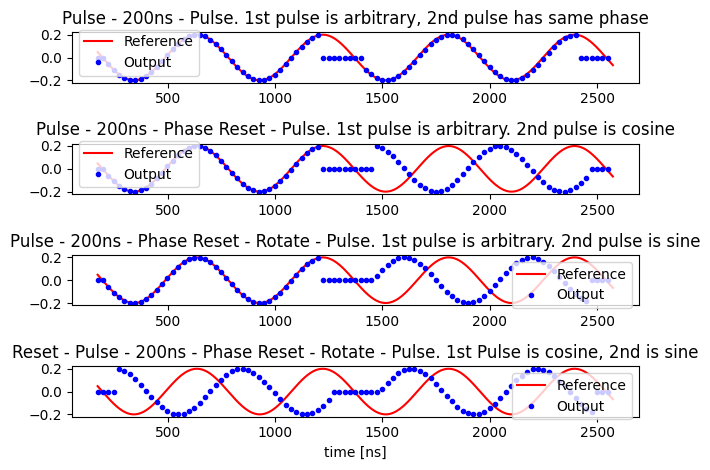

In [2]:

# Create a quantum machine based on the configuration.

with program() as no_reset_ph:
    # This program plays the same pulse twice with 200ns in between.
    play("const", "qubit")
    wait(50, "qubit")  # 50 cycles = 200 ns
    play("const", "qubit")

with program() as reset_ph:
    # This program plays the same pulse twice with 200ns in between, but with the phase of the 2nd pulse reset.
    play("const", "qubit")
    wait(50, "qubit")  # 50 cycles = 200 ns
    reset_phase("qubit")
    play("const", "qubit")

with program() as reset_ph_and_rotate:
    # This program plays the same pulse twice with 200ns in between, but with the phase of the 2nd pulse reset
    # and shifted by pi/2.
    play("const", "qubit")
    wait(50, "qubit")  # 50 cycles = 200 ns
    reset_phase("qubit")
    frame_rotation_2pi(-0.25, "qubit")
    play("const", "qubit")

with program() as reset_both_ph_and_rotate:
    # This program plays the pulse twice with 200ns in between, 1st pulse is phase reset and 2nd pulse is phase
    # reset and shifted by pi/2.
    reset_phase("qubit")
    play("const", "qubit")
    wait(50, "qubit")  # 50 cycles = 200 ns
    reset_phase("qubit")
    frame_rotation_2pi(-0.25, "qubit")
    play("const", "qubit")

# Simulate 1st program
job = qmm.simulate(config, no_reset_ph, SimulationConfig(int(800)))
samples = job.get_simulated_samples()

# This creates the reference sin wave according to the 1st pulse. It is made in this manner because the exact timing
# can change between versions, but this method will maintain compatibility.
startI = samples.con1.analog["1"].nonzero()[0][0]
t = np.arange(startI - 50, startI + 500)
data_fit = samples.con1.analog["1"][startI - 50 : startI + 500]
fit_func = lambda x: x[0] * np.sin(x[1] * t + x[2]) - data_fit
est_amp, est_freq, est_phase = leastsq(fit_func, [0.2, 2 * np.pi * 2.1e-3, 0])[0]
t_ref = np.arange(startI - 50, startI + 2350)
ref_sin = est_amp * np.sin(est_freq * t_ref + est_phase)

# Plot 1st program
ax1 = plt.subplot(411)
plt.plot(t_ref, ref_sin, "r")
plt.plot(
    np.arange(startI - 50, startI + 2350, 25),
    samples.con1.analog["1"][startI - 50 : startI + 2350 : 25],
    "b.",
)  # Plot every 25th point (for clarity)
plt.legend(("Reference", "Output"))
plt.title("Pulse - 200ns - Pulse. 1st pulse is arbitrary, 2nd pulse has same phase")

# Simulate 2nd program
job = qmm.simulate(config, reset_ph, SimulationConfig(int(800)))
samples = job.get_simulated_samples()
plt.subplot(412, sharex=ax1)
plt.plot(t_ref, ref_sin, "r")
plt.plot(
    np.arange(startI - 50, startI + 2350, 25),
    samples.con1.analog["1"][startI - 50 : startI + 2350 : 25],
    "b.",
)  # Plot every 25th point (for clarity)
plt.legend(("Reference", "Output"))
plt.title("Pulse - 200ns - Phase Reset - Pulse. 1st pulse is arbitrary. 2nd pulse is cosine")

# Simulate 3rd program
job = qmm.simulate(config, reset_ph_and_rotate, SimulationConfig(int(800)))
samples = job.get_simulated_samples()
plt.subplot(413, sharex=ax1)
plt.plot(t_ref, ref_sin, "r")
plt.plot(
    np.arange(startI - 50, startI + 2350, 25),
    samples.con1.analog["1"][startI - 50 : startI + 2350 : 25],
    "b.",
)  # Plot every 25th point (for clarity)
plt.legend(("Reference", "Output"))
plt.title("Pulse - 200ns - Phase Reset - Rotate - Pulse. 1st pulse is arbitrary. 2nd pulse is sine")

# Simulate 4rd program
job = qmm.simulate(config, reset_both_ph_and_rotate, SimulationConfig(int(800)))
samples = job.get_simulated_samples()
plt.subplot(414, sharex=ax1)
plt.plot(t_ref, ref_sin, "r")
plt.plot(
    np.arange(startI - 50, startI + 2350, 25),
    samples.con1.analog["1"][startI - 50 : startI + 2350 : 25],
    "b.",
)  # Plot every 25th point (for clarity)
plt.legend(("Reference", "Output"))
plt.title("Reset - Pulse - 200ns - Phase Reset - Rotate - Pulse. 1st Pulse is cosine, 2nd is sine")

plt.xlabel("time [ns]")
plt.tight_layout()
plt.show()
